# 🧭 DICOMweb + FHIR Navigator with MedGemma

> **Goal:** go beyond “image → caption” and show a lightweight *navigator* workflow that combines **DICOM provenance + patient context + structured model outputs**.

---

## 🧩 The Problem
Most medical vision demos end at **captioning**. Real clinical workflows are closer to **navigation**:
- locate *where* an image came from (Study / Series / Instance),
- review **patient context** (problems, vitals, labs),
- produce outputs that are **structured**, reviewable, and safe when uncertain.

Also, Kaggle doesn’t provide a single dataset where **patient ↔ imaging study** is already linked cleanly. A demo must show *navigation + context* without pretending it is a real clinical linkage.

---

## ✅ The Solution
This notebook builds a lightweight **Navigator** pipeline:

1. **DICOMweb browsing (QIDO-RS)**  
   Select a Study / Series / Instance and fetch a rendered preview frame.

2. **FHIR R4 patient context**  
   Pull a public Patient + small sets of Conditions and Observations.  
   If a public server is flaky (e.g., 500 errors), the notebook **fails over** and still runs.

3. **MedGemma → JSON-first outputs**  
   - **Imaging Summary (JSON)** from the image  
   - **Pre-visit Packet (JSON)** from *image + EHR context*, written conservatively

---

## ⚠️ Demo Linkage Rule (Important)
🟥 **The FHIR patient context may not be clinically linked to the DICOM study.**  
Prompts are designed to **avoid inventing a story** that ties unrelated EHR to the image.

When things don’t align:
- use **unknown**,
- keep **confidence low**,
- keep **triage conservative**.

---

## 🛠️ Tech Stack
- 🐍 Python (requests, pathlib, json, regex)
- 🖼️ DICOMweb (QIDO-RS + WADO-RS rendered preview) via public demo servers
- 🧾 FHIR R4 (Patient / Condition / Observation) via public servers (with failover)
- 🤖 MedGemma (`google/medgemma-4b-it`) via Hugging Face Transformers
- 🧪 Robust JSON extraction + validation + retry
- 🧩 Gradio mini demo UI

---

## ✨ Key Innovations / Novelties
- 🧭 **Navigator framing:** DICOM selection + EHR context + structured outputs (not just captions)
- 🧱 **Strict JSON schemas:** model outputs become usable for downstream pipelines
- 🛡️ **Robustness:** brace-balanced JSON extraction + schema checks + retry
- 🧊 **Conservative behavior:** explicit linkage disclaimer prevents false causality
- 🧾 **Reproducible traces:** each run writes small reviewable artifacts under `artifacts/`

---

## 📦 Imaging + Context Sources
- **Imaging:** public DICOM demo servers (DICOMweb)
- **EHR:** public FHIR servers (FHIR R4)
- **Endpoints used:**
  - DICOMweb: `/studies`, `/series`, `/instances`, and `/rendered`
  - FHIR R4: `Patient`, `Condition`, `Observation`

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/med-gemma-impact-challenge/Hackathon dataset.txt


In [2]:
!python -V
!python -m pip --version
!python -m pip show transformers tokenizers accelerate huggingface_hub dicomweb-client pydicom gradio | sed -n '1,80p' || true
!python -m pip install -q --no-cache-dir dicomweb-client pydicom

Python 3.12.12
pip 24.1.2 from /usr/local/lib/python3.12/dist-packages/pip (python 3.12)
Name: transformers
Version: 4.57.1
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.12/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: kaggle-environments, peft, sentence-transformers
---
Name: tokenizers
Version: 0.22.1
Summary: 
Home-page: https://github.com/huggingface/tokenizers
Author: 
Author-email: Nicolas Patry <patry.nicolas@protonmail.com>, Anthony Moi <anthony@huggingface.co>
License: 
Location: /usr/local/lib/python3.12/dist-packages
Requires: huggingface-hub
Required-b

## ✅ Cell 0 — Environment sanity checks

Quick checks to avoid silent failures:
- confirms the DICOMweb server is reachable
- confirms the FHIR server responds
- prints basic health/version info

If a public server is down temporarily, you can re-run or switch endpoints in the config cell.

In [3]:
import os, sys, json, time, textwrap
from pathlib import Path

ART_DIR = Path("artifacts")
ART_DIR.mkdir(exist_ok=True)

print("Python:", sys.version.split()[0])

# Basic GPU sanity (no hard dependency yet)
try:
    import torch
    print("Torch:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("GPU:", torch.cuda.get_device_name(0))
except Exception as e:
    print("Torch not ready:", repr(e))

# Show Kaggle inputs (expected to be empty/placeholder for this hackathon)
INPUT_ROOT = Path("/kaggle/input")
if INPUT_ROOT.exists():
    top = sorted([p.name for p in INPUT_ROOT.iterdir()])
    print("\n/kaggle/input contains:", top)
    # Try to locate competition folder
    comp = [p for p in INPUT_ROOT.iterdir() if "med" in p.name.lower() and "gemma" in p.name.lower()]
    if comp:
        comp = comp[0]
        print("Competition folder:", comp)
        files = sorted([p.name for p in comp.iterdir()])
        print("Competition files:", files)
        for fn in files:
            fp = comp / fn
            print(f" - {fn}: {fp.stat().st_size} bytes")
else:
    print("No /kaggle/input found (are you running on Kaggle?).")

# Internet check (you MUST enable Internet in Kaggle notebook settings)
import requests
try:
    r = requests.get("http://hapi.fhir.org/baseR4/metadata", timeout=10)
    print("\nInternet check: OK (HAPI FHIR metadata status)", r.status_code)
except Exception as e:
    print("\nInternet check FAILED.")
    print("→ In Kaggle: Notebook settings (right panel) → Internet = ON")
    print("Error:", repr(e))

# Hugging Face token presence check (do not print token)
hf_present = bool(os.environ.get("HF_TOKEN"))
print("\nHF_TOKEN present in environment:", hf_present)

print("\n✅ Cell 0 done. Next: config + endpoints + robust DICOMweb image fetch.")

Python: 3.12.12
Torch: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4

/kaggle/input contains: ['med-gemma-impact-challenge']
Competition folder: /kaggle/input/med-gemma-impact-challenge
Competition files: ['Hackathon dataset.txt']
 - Hackathon dataset.txt: 0 bytes

Internet check: OK (HAPI FHIR metadata status) 200

HF_TOKEN present in environment: False

✅ Cell 0 done. Next: config + endpoints + robust DICOMweb image fetch.


## ✅ Cell 1 — Config and endpoints

This cell defines:
- DICOMweb endpoints (QIDO-RS + WADO-RS rendered preview)
- FHIR base URL + timeouts
- model ID (`google/medgemma-4b-it`)
- artifact directory paths

🟦 Tip: if a public FHIR server is unstable, later cells will automatically try alternate servers.

In [4]:
import os, json, time
from dataclasses import dataclass
from pathlib import Path

ART_DIR = Path("artifacts")
ART_DIR.mkdir(exist_ok=True)

@dataclass
class CFG:
    # FHIR
    FHIR_BASE: str = "http://hapi.fhir.org/baseR4"
    FHIR_TIMEOUT: int = 20

    # DICOMweb: we will probe these in order until one works
    DICOM_CANDIDATES: tuple = (
        # DICOMcloud demo (often works, but sometimes rate-limited)
        {"name": "dicomcloud", "base_url": "https://demo.dicomcloud.com/dicomweb"},
        # Orthanc public demo (often works)
        {"name": "orthanc_demo", "base_url": "https://demo.orthanc-server.com/dicom-web"},
        # Another Orthanc demo (sometimes works)
        {"name": "orthanc_ucl", "base_url": "https://orthanc.uclouvain.be/demo/dicom-web"},
    )
    DICOM_TIMEOUT: int = 25

    # Study/series selection behavior
    MAX_STUDIES_TO_TRY: int = 10
    PREFER_MODALITIES: tuple = ("CT", "MR", "CR", "DX", "US", "XA")  # prefer image modalities
    AVOID_MODALITIES: tuple = ("SR", "PR")  # structured report / presentation state

    # Rendering preference: we will try to fetch a rendered frame (JPEG/PNG)
    # before trying pydicom pixel decoding (more robust).
    RENDER_ACCEPT: str = "image/jpeg"

    # MedGemma settings (will stay OFF unless token exists)
    MODEL_ID: str = "google/medgemma-4b-it"
    USE_MEDGEMMA: bool = False  # auto-enabled if HF_TOKEN exists below

cfg = CFG()

# -------------------------
# Environment & token logic
# -------------------------
hf_token = os.environ.get("HF_TOKEN", "").strip()
if hf_token:
    cfg.USE_MEDGEMMA = True

print("CFG:")
print(" - FHIR_BASE:", cfg.FHIR_BASE)
print(" - DICOM candidates:", [c["name"] for c in cfg.DICOM_CANDIDATES])
print(" - Render Accept:", cfg.RENDER_ACCEPT)
print(" - MODEL_ID:", cfg.MODEL_ID)
print(" - USE_MEDGEMMA:", cfg.USE_MEDGEMMA)

if not cfg.USE_MEDGEMMA:
    print("\n⚠️ HF_TOKEN not found.")
    print("   You can still complete DICOMweb + FHIR + linking + artifacts.")
    print("   When ready: add HF_TOKEN in Kaggle → Add-ons → Secrets, then restart kernel.")
else:
    print("\n✅ HF_TOKEN found. MedGemma steps will be enabled later.")

# -------------------------
# Quick connectivity pings
# -------------------------
import requests

def ping_url(url: str, timeout: int = 10) -> bool:
    try:
        r = requests.get(url, timeout=timeout)
        return r.status_code in (200, 401, 403)  # 401/403 still means endpoint exists
    except Exception:
        return False

# FHIR ping
fhir_ok = ping_url(cfg.FHIR_BASE + "/metadata", timeout=cfg.FHIR_TIMEOUT)
print("\nFHIR /metadata reachable:", fhir_ok)

# DICOMweb base ping (not all servers respond nicely at base URL; we still probe later via QIDO)
for c in cfg.DICOM_CANDIDATES:
    ok = ping_url(c["base_url"], timeout=10)
    print(f"DICOM base reachable ({c['name']}):", ok)

# Save config snapshot for traceability
cfg_path = ART_DIR / "navigator_v2_config.json"
with open(cfg_path, "w", encoding="utf-8") as f:
    json.dump({
        "FHIR_BASE": cfg.FHIR_BASE,
        "FHIR_TIMEOUT": cfg.FHIR_TIMEOUT,
        "DICOM_CANDIDATES": cfg.DICOM_CANDIDATES,
        "DICOM_TIMEOUT": cfg.DICOM_TIMEOUT,
        "MAX_STUDIES_TO_TRY": cfg.MAX_STUDIES_TO_TRY,
        "PREFER_MODALITIES": cfg.PREFER_MODALITIES,
        "AVOID_MODALITIES": cfg.AVOID_MODALITIES,
        "RENDER_ACCEPT": cfg.RENDER_ACCEPT,
        "MODEL_ID": cfg.MODEL_ID,
        "USE_MEDGEMMA": cfg.USE_MEDGEMMA,
        "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    }, f, indent=2)

print("\n✅ Saved:", str(cfg_path))
print("Next cell will: install/load dicomweb-client, probe working DICOMweb, then pick a study/series/instance safely.")

CFG:
 - FHIR_BASE: http://hapi.fhir.org/baseR4
 - DICOM candidates: ['dicomcloud', 'orthanc_demo', 'orthanc_ucl']
 - Render Accept: image/jpeg
 - MODEL_ID: google/medgemma-4b-it
 - USE_MEDGEMMA: False

⚠️ HF_TOKEN not found.
   You can still complete DICOMweb + FHIR + linking + artifacts.
   When ready: add HF_TOKEN in Kaggle → Add-ons → Secrets, then restart kernel.

FHIR /metadata reachable: True
DICOM base reachable (dicomcloud): False
DICOM base reachable (orthanc_demo): False
DICOM base reachable (orthanc_ucl): False

✅ Saved: artifacts/navigator_v2_config.json
Next cell will: install/load dicomweb-client, probe working DICOMweb, then pick a study/series/instance safely.


## ✅ Cell 2 — DICOMweb browse + select a Study/Series/Instance

This cell:
- lists available studies
- picks a study → series → instance (SOP)
- downloads a rendered preview image (WADO-RS `/rendered`)

🟩 Output: one image preview + a DICOM selection object (Study/Series/SOP IDs) to drive the rest of the notebook.

✅ Working DICOMweb: orthanc_demo
   QIDO: https://demo.orthanc-server.com/dicom-web
   WADO: https://demo.orthanc-server.com/dicom-web

Selected Study:
 - StudyInstanceUID: 2.16.840.1.113669.632.20.1211.10000315526
 - ModalitiesInStudy: ['CT']
 - StudyDescription: 

Selected Series:
 - SeriesInstanceUID: 1.3.12.2.1107.5.1.4.54693.30000006100507010800000005268
 - Modality: CT
 - SeriesDescription: Pied/cheville  1.0mm std

Selected Instance:
 - SOPInstanceUID: 1.3.12.2.1107.5.1.4.54693.30000006100507010800000005328

✅ Rendered image fetched: image/jpeg
Image size: (512, 512)

✅ Saved selection: artifacts/dicom_selection_20260205_210850.json
✅ Saved image: artifacts/dicom_render_orthanc_demo_20260205_210850.jpg


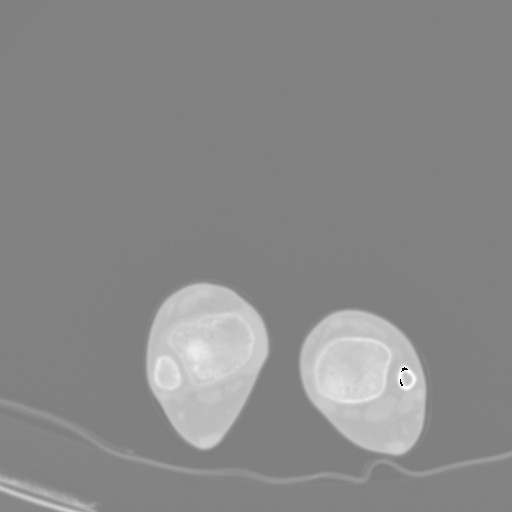

In [5]:
import json, time
from pathlib import Path
import requests
from PIL import Image
from io import BytesIO

ART_DIR = Path("artifacts")
ART_DIR.mkdir(exist_ok=True)

# ---- Candidate endpoints (QIDO + WADO roots)
# Some servers expose /studies directly under base_url; some need qidors/wadors.
CANDIDATES = [
    {"name": "dicomcloud",   "qido_root": "https://demo.dicomcloud.com/dicomweb/qidors", "wado_root": "https://demo.dicomcloud.com/dicomweb/wadors"},
    {"name": "orthanc_demo", "qido_root": "https://demo.orthanc-server.com/dicom-web",   "wado_root": "https://demo.orthanc-server.com/dicom-web"},
    {"name": "orthanc_ucl",  "qido_root": "https://orthanc.uclouvain.be/demo/dicom-web", "wado_root": "https://orthanc.uclouvain.be/demo/dicom-web"},
]

HEAD_JSON = {"Accept": "application/dicom+json"}
TIMEOUT = cfg.DICOM_TIMEOUT

def _get(url, params=None, headers=None, timeout=TIMEOUT):
    return requests.get(url, params=params, headers=headers, timeout=timeout)

def dcm_first(d, tag, default=None):
    """Extract first value from DICOM JSON tag dict safely."""
    try:
        v = d.get(tag, {}).get("Value", None)
        if not v:
            return default
        x = v[0]
        # PatientName-like dict: {"Alphabetic": "..."}
        if isinstance(x, dict):
            return x.get("Alphabetic") or x.get("Ideographic") or x.get("Phonetic") or str(x)
        return x
    except Exception:
        return default

def dcm_list(d, tag):
    try:
        v = d.get(tag, {}).get("Value", [])
        return v if isinstance(v, list) else []
    except Exception:
        return []

def probe_dicomweb():
    """Return first candidate that answers QIDO /studies?limit=1 with a JSON list."""
    for c in CANDIDATES:
        try:
            r = _get(f"{c['qido_root'].rstrip('/')}/studies", params={"limit": 1}, headers=HEAD_JSON)
            if r.status_code == 200:
                js = r.json()
                if isinstance(js, list) and len(js) >= 1:
                    return c, js[0]
        except Exception:
            pass
    return None, None

cand, first_study = probe_dicomweb()
if cand is None:
    raise RuntimeError(
        "No DICOMweb candidate responded to QIDO /studies. "
        "Try again later (public demos can be flaky) or add another endpoint."
    )

print("✅ Working DICOMweb:", cand["name"])
print("   QIDO:", cand["qido_root"])
print("   WADO:", cand["wado_root"])

# ---- Pull a few studies and choose one that matches preferred modalities (if possible)
studies = _get(f"{cand['qido_root'].rstrip('/')}/studies",
               params={"limit": cfg.MAX_STUDIES_TO_TRY},
               headers=HEAD_JSON).json()

def study_score(st):
    mods = set(dcm_list(st, "00080061"))  # ModalitiesInStudy
    # Prefer any overlap with cfg.PREFER_MODALITIES
    pref = len(mods.intersection(set(cfg.PREFER_MODALITIES)))
    return pref

studies_sorted = sorted(studies, key=study_score, reverse=True)
study = studies_sorted[0]
study_uid = dcm_first(study, "0020000D")  # StudyInstanceUID
mods = dcm_list(study, "00080061")
desc = dcm_first(study, "00081030", "")   # StudyDescription
print("\nSelected Study:")
print(" - StudyInstanceUID:", study_uid)
print(" - ModalitiesInStudy:", mods)
print(" - StudyDescription:", desc)

# ---- List series and choose a usable image series (skip SR/PR; prefer CT/MR/CR/DX/US/XA)
series_list = _get(f"{cand['qido_root'].rstrip('/')}/studies/{study_uid}/series",
                   params={"limit": 200},
                   headers=HEAD_JSON).json()

def series_ok(sr):
    mod = dcm_first(sr, "00080060", "")  # Modality
    if mod in cfg.AVOID_MODALITIES:
        return False
    return True

def series_score(sr):
    mod = dcm_first(sr, "00080060", "")
    return (1 if mod in cfg.PREFER_MODALITIES else 0)

usable = [s for s in series_list if series_ok(s)]
if not usable:
    raise RuntimeError("No usable series found (all were SR/PR or empty). Try another study.")

usable_sorted = sorted(usable, key=series_score, reverse=True)
series = usable_sorted[0]
series_uid = dcm_first(series, "0020000E")  # SeriesInstanceUID
series_mod = dcm_first(series, "00080060", "")
series_desc = dcm_first(series, "0008103E", "")
print("\nSelected Series:")
print(" - SeriesInstanceUID:", series_uid)
print(" - Modality:", series_mod)
print(" - SeriesDescription:", series_desc)

# ---- List instances and pick the first
instances = _get(f"{cand['qido_root'].rstrip('/')}/studies/{study_uid}/series/{series_uid}/instances",
                 params={"limit": 50},
                 headers=HEAD_JSON).json()
if not instances:
    raise RuntimeError("No instances found in selected series.")

inst = instances[0]
sop_uid = dcm_first(inst, "00080018")  # SOPInstanceUID
print("\nSelected Instance:")
print(" - SOPInstanceUID:", sop_uid)

# ---- Try to fetch a rendered image (robust)
render_urls = [
    f"{cand['wado_root'].rstrip('/')}/studies/{study_uid}/series/{series_uid}/instances/{sop_uid}/rendered",
]
# Some servers may prefer PNG
accepts = [cfg.RENDER_ACCEPT, "image/png"]

img_bytes = None
last_err = None
for url in render_urls:
    for acc in accepts:
        try:
            r = _get(url, headers={"Accept": acc}, timeout=TIMEOUT)
            if r.status_code == 200 and r.content:
                img_bytes = r.content
                used_url, used_acc = url, acc
                break
        except Exception as e:
            last_err = e
    if img_bytes:
        break

if img_bytes is None:
    raise RuntimeError(f"Rendered image fetch failed. Last error: {repr(last_err)}")

img = Image.open(BytesIO(img_bytes)).convert("RGB")
print("\n✅ Rendered image fetched:", used_acc)
print("Image size:", img.size)

# ---- Save artifacts
ts = time.strftime("%Y%m%d_%H%M%S")
img_path = ART_DIR / f"dicom_render_{cand['name']}_{ts}.jpg"
img.save(img_path, quality=95)

sel = {
    "dicomweb": cand,
    "study_uid": study_uid,
    "series_uid": series_uid,
    "sop_uid": sop_uid,
    "study_modalities": mods,
    "study_description": desc,
    "series_modality": series_mod,
    "series_description": series_desc,
    "render_url": used_url,
    "render_accept": used_acc,
    "saved_image": str(img_path),
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
}
sel_path = ART_DIR / f"dicom_selection_{ts}.json"
with open(sel_path, "w", encoding="utf-8") as f:
    json.dump(sel, f, indent=2)

print("\n✅ Saved selection:", sel_path)
print("✅ Saved image:", img_path)

# Show image inline (Kaggle displays PIL images)
img

In [6]:
import requests
FHIR_BASE = "https://hapi.fhir.org/baseR4"
print("metadata:", requests.get(f"{FHIR_BASE}/metadata", timeout=20).status_code)

metadata: 200


## ✅ Cell 3 — FHIR patient context + build a linked case (patient ↔ study)

This cell:
- pulls a public **FHIR Patient** plus small sets of **Conditions** and **Observations**
- handles public-server instability (e.g., transient 500 errors) by trying alternate bases
- builds a single “case” object that pairs:
  - DICOM selection (Study/Series/SOP + preview path)
  - FHIR context (patient + conditions + observations)

🟥 Reminder: This is a *demo linkage* (navigation + context), not guaranteed clinical linkage.

In [7]:
import json, time, re
from pathlib import Path
import requests

ART_DIR = Path("artifacts")
ART_DIR.mkdir(exist_ok=True)

FHIR_HEADERS = {"Accept": "application/fhir+json"}
FHIR_TIMEOUT = max(int(getattr(cfg, "FHIR_TIMEOUT", 20)), 30)

def safe_get_json(url, params=None, timeout=FHIR_TIMEOUT, retries=4):
    last_err = None
    for attempt in range(retries):
        try:
            r = requests.get(url, params=params, headers=FHIR_HEADERS, timeout=timeout)
            if r.status_code in (429, 500, 502, 503, 504):
                time.sleep(1.0 * (attempt + 1))
                continue
            r.raise_for_status()
            return r.json()
        except Exception as e:
            last_err = e
            time.sleep(0.7 * (attempt + 1))
    return {"_error": str(last_err)[:200], "_url": url, "_params": params}

def ref_to_patient_id(ref: str):
    if not ref:
        return None
    m = re.search(r"Patient/([A-Za-z0-9\-.]+)", ref)
    return m.group(1) if m else None

def patient_name(p):
    try:
        nm = (p.get("name") or [{}])[0]
        given = " ".join(nm.get("given", []) or [])
        fam = nm.get("family", "") or ""
        full = (given + " " + fam).strip()
        return full if full else "Unknown"
    except Exception:
        return "Unknown"

def code_text(resource):
    cc = resource.get("code", {})
    if cc.get("text"):
        return cc["text"]
    coding = (cc.get("coding") or [{}])[0]
    return coding.get("display") or coding.get("code") or "Unknown"

def obs_value(o):
    if "valueQuantity" in o:
        vq = o["valueQuantity"]
        return f"{vq.get('value', '')} {vq.get('unit', '')}".strip()
    for k in ["valueString", "valueCodeableConcept", "valueInteger", "valueBoolean"]:
        if k in o:
            if k == "valueCodeableConcept":
                cc = o[k]
                if cc.get("text"):
                    return cc["text"]
                coding = (cc.get("coding") or [{}])[0]
                return coding.get("display") or coding.get("code") or "Unknown"
            return str(o[k])
    return "Unknown"

# ---- Load the latest dicom selection
sel_files = sorted(ART_DIR.glob("dicom_selection_*.json"))
if not sel_files:
    raise FileNotFoundError("No dicom_selection_*.json found. Run Cell 2 first.")
sel_path = sel_files[-1]
sel = json.loads(sel_path.read_text(encoding="utf-8"))

print("Using DICOM selection:", sel_path.name)
print(" - Study:", sel["study_uid"])
print(" - Series:", sel["series_uid"])
print(" - SOP:", sel["sop_uid"])
print(" - Image:", sel["saved_image"])

# ---- Pick a working FHIR base (HAPI sometimes returns 500 on searches)
def pick_working_fhir_base(candidates):
    for base in candidates:
        if not base:
            continue
        base = base.rstrip("/").replace("http://hapi.fhir.org", "https://hapi.fhir.org")
        try:
            m = requests.get(f"{base}/metadata", headers=FHIR_HEADERS, timeout=10)
            if m.status_code != 200:
                continue
            p = requests.get(f"{base}/Patient", params={"_count": 1}, headers=FHIR_HEADERS, timeout=10)
            if p.status_code == 200:
                js = p.json()
                if js.get("resourceType") == "Bundle":
                    return base
        except Exception:
            pass
    return "https://hapi.fhir.org/baseR4"

FHIR_BASE_CANDIDATES = [
    getattr(cfg, "FHIR_BASE", "").rstrip("/"),
    "https://r4.smarthealthit.org",
    "https://server.fire.ly/r4",
    "https://hapi.fhir.org/baseR4",
]
FHIR_BASE = pick_working_fhir_base(FHIR_BASE_CANDIDATES)
cfg.FHIR_BASE = FHIR_BASE  # keeps later cells consistent
print("✅ Using FHIR_BASE:", FHIR_BASE)

def _uniq_preserve(xs):
    seen, out = set(), []
    for x in xs:
        if x and x not in seen:
            out.append(x); seen.add(x)
    return out

def _patient_ids_from_bundle(bundle):
    ids = []
    for e in (bundle.get("entry") or []):
        res = (e.get("resource") or {})
        subj = (res.get("subject") or {}).get("reference", "") or ""
        pid = ref_to_patient_id(subj)
        if pid:
            ids.append(pid)
    return _uniq_preserve(ids)

def get_conditions(pid, n=20):
    # try subject first, then patient (server-dependent)
    b = safe_get_json(f"{FHIR_BASE}/Condition", params={"subject": f"Patient/{pid}", "_count": n})
    if b.get("entry") is not None:
        return b
    return safe_get_json(f"{FHIR_BASE}/Condition", params={"patient": f"Patient/{pid}", "_count": n})

def get_observations(pid, n=20):
    b = safe_get_json(f"{FHIR_BASE}/Observation", params={"subject": f"Patient/{pid}", "_count": n})
    if b.get("entry") is not None:
        return b
    return safe_get_json(f"{FHIR_BASE}/Observation", params={"patient": f"Patient/{pid}", "_count": n})

def pick_patient_with_data(max_patients=60):
    # lightweight “seed” bundles
    cond_bundle = safe_get_json(f"{FHIR_BASE}/Condition", params={"_count": 20})
    obs_bundle  = safe_get_json(f"{FHIR_BASE}/Observation", params={"_count": 20})

    candidate_ids = _uniq_preserve(_patient_ids_from_bundle(cond_bundle) + _patient_ids_from_bundle(obs_bundle))

    if not candidate_ids:
        pat_bundle = safe_get_json(f"{FHIR_BASE}/Patient", params={"_count": max_patients})
        candidate_ids = _uniq_preserve([ (e.get("resource") or {}).get("id") for e in (pat_bundle.get("entry") or []) ])

    for pid in candidate_ids[:max_patients]:
        if not pid:
            continue
        conds = get_conditions(pid, n=1)
        obss  = get_observations(pid, n=1)
        if (conds.get("entry") or []) or (obss.get("entry") or []):
            patient = safe_get_json(f"{FHIR_BASE}/Patient/{pid}")
            conds = get_conditions(pid, n=20)
            obss  = get_observations(pid, n=20)
            return pid, patient, conds, obss

    return None, {}, {"entry": []}, {"entry": []}

patient_id, patient, conds, obss = pick_patient_with_data()

if not patient_id:
    print("⚠️ Could not find a Patient with Condition/Observation today. Falling back to demo context.")
    patient_id = "demo"
    patient = {}
    conds, obss = {"entry": []}, {"entry": []}

# Build cond_items / obs_items
cond_items = []
for e in (conds.get("entry") or [])[:10]:
    c = e.get("resource") or {}
    cond_items.append({
        "condition": code_text(c),
        "clinicalStatus": (c.get("clinicalStatus", {}).get("coding") or [{}])[0].get("code", ""),
        "verificationStatus": (c.get("verificationStatus", {}).get("coding") or [{}])[0].get("code", ""),
    })

obs_items = []
for e in (obss.get("entry") or [])[:10]:
    o = e.get("resource") or {}
    obs_items.append({
        "observation": code_text(o),
        "value": obs_value(o),
        "status": o.get("status", ""),
    })

patient_brief = {
    "id": patient.get("id", patient_id),
    "name": patient_name(patient),
    "gender": patient.get("gender", "unknown"),
    "birthDate": patient.get("birthDate", "unknown"),
}

# ---- Build linked case (same schema as your original)
ts = time.strftime("%Y%m%d_%H%M%S")
case = {
    "case_id": f"case_{ts}",
    "dicom": {
        "dicomweb_name": sel["dicomweb"]["name"],
        "study_uid": sel["study_uid"],
        "series_uid": sel["series_uid"],
        "sop_uid": sel["sop_uid"],
        "series_modality": sel.get("series_modality", ""),
        "series_description": sel.get("series_description", ""),
        "render_url": sel.get("render_url", ""),
        "image_path": sel["saved_image"],
    },

    # NEW: provenance + linkage disclaimer
    "fhir": {
        "base": FHIR_BASE,
        "patient_id": patient_id,
        "conditions_n": len(cond_items),
        "observations_n": len(obs_items),
        "linkage_mode": "demo_fallback" if patient_id == "demo" else "random_public_patient",
        "linkage_disclaimer": "FHIR patient context is a public demo and may be unrelated to the DICOM image. Do not infer causality."
    },

    "patient": patient_brief,
    "conditions": cond_items,
    "observations": obs_items,

    # keep note (optionally strengthen it)
    "note": "Demo navigation only: FHIR context and public DICOM study are not clinically linked.",
}

out_path = ART_DIR / f"linked_case_{ts}.json"
out_path.write_text(json.dumps(case, indent=2), encoding="utf-8")

print("\n✅ Linked case saved:", out_path)
print("Patient:", patient_brief["name"], "|", patient_brief["gender"], "|", patient_brief["birthDate"])
print("Conditions:", len(cond_items), "| Observations:", len(obs_items))

Using DICOM selection: dicom_selection_20260205_210850.json
 - Study: 2.16.840.1.113669.632.20.1211.10000315526
 - Series: 1.3.12.2.1107.5.1.4.54693.30000006100507010800000005268
 - SOP: 1.3.12.2.1107.5.1.4.54693.30000006100507010800000005328
 - Image: artifacts/dicom_render_orthanc_demo_20260205_210850.jpg
✅ Using FHIR_BASE: https://r4.smarthealthit.org

✅ Linked case saved: artifacts/linked_case_20260205_210854.json
Patient: Kizzie Bode | female | 2006-03-30
Conditions: 4 | Observations: 10


In [8]:
from kaggle_secrets import UserSecretsClient
from huggingface_hub import login, HfApi, hf_hub_download

MODEL_ID = cfg.MODEL_ID

hf_token = UserSecretsClient().get_secret("HF_TOKEN").strip()
# Make sure HF hub + transformers see it
import os
os.environ["HF_TOKEN"] = hf_token
os.environ["HUGGINGFACE_HUB_TOKEN"] = hf_token

login(token=hf_token, add_to_git_credential=False)

me = HfApi().whoami(token=hf_token)
print("✅ HF whoami:", me.get("name", me.get("email", "unknown")))

# Fail-fast: confirms gated access works from THIS kernel
_ = hf_hub_download(repo_id=MODEL_ID, filename="config.json", token=hf_token)
print("✅ Model access confirmed from Kaggle.")

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


✅ HF whoami: Ucchwas09


config.json:   0%|          | 0.00/2.47k [00:00<?, ?B/s]

✅ Model access confirmed from Kaggle.


## ✅ Cell 4 — Load MedGemma (with safe chat-format generation)

This cell loads **MedGemma** and defines a **single generation function** that:
- uses the model’s **chat template** (recommended for best results)
- supports image + text prompts
- includes a small sanity test

🟦 If you see warnings about `do_sample` / `temperature`, it usually means those args are ignored by the processor. The generation still works.

In [9]:
import os, json
from pathlib import Path
import torch
from PIL import Image
from transformers import pipeline

os.environ["TOKENIZERS_PARALLELISM"] = "false"

ART_DIR = Path("artifacts")
ART_DIR.mkdir(exist_ok=True)

# Load latest linked case + image
case_files = sorted(ART_DIR.glob("linked_case_*.json"))
if not case_files:
    raise FileNotFoundError("No linked_case_*.json found. Run Cell 3 first.")
case_path = case_files[-1]
case = json.loads(case_path.read_text(encoding="utf-8"))

img_path = case["dicom"]["image_path"]
img = Image.open(img_path).convert("RGB")

print("Using case:", case_path.name)
print("Image:", img_path, "| size:", img.size)

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16 if device == "cuda" else torch.float32
print("Device:", device, "| dtype:", dtype)

# HF token sanity (don't print it)
try:
    from kaggle_secrets import UserSecretsClient
    _tok = UserSecretsClient().get_secret("HF_TOKEN")
    assert _tok and len(_tok) > 10
    print("✅ HF_TOKEN available via Kaggle Secrets")
except Exception:
    print("⚠️ HF_TOKEN not available. Kaggle → Add-ons → Secrets → add HF_TOKEN → restart kernel.")

MODEL_ID = cfg.MODEL_ID

pipe = pipeline(
    task="image-text-to-text",
    model=MODEL_ID,
    dtype=dtype,                        # torch_dtype deprecated
    device_map="auto" if device == "cuda" else None,
)

def _ensure_image_token(text: str) -> str:
    tok = "<start_of_image>"
    text = (text or "").strip()
    return text if tok in text else f"{tok} {text}"

def _extract_text(out):
    """
    Return best-effort assistant text for many possible HF pipeline shapes.
    """
    if out is None:
        return ""
    if isinstance(out, list) and len(out) > 0:
        o0 = out[0]
        gt = o0.get("generated_text", o0)

        # Case A: plain string
        if isinstance(gt, str):
            return gt.strip()

        # Case B: chat-like list of messages
        if isinstance(gt, list):
            # find last assistant-like msg
            for msg in reversed(gt):
                if isinstance(msg, dict) and msg.get("role") in ("assistant", "model"):
                    content = msg.get("content", "")
                    if isinstance(content, str):
                        return content.strip()
                    if isinstance(content, list):
                        parts = []
                        for p in content:
                            if isinstance(p, dict) and p.get("type") == "text":
                                parts.append(p.get("text", ""))
                            elif isinstance(p, str):
                                parts.append(p)
                        return "\n".join([x for x in parts if x]).strip()
                    return str(content).strip()
            return str(gt).strip()

        # fallback
        return str(gt).strip()
    return str(out).strip()

def medgemma_generate_chat(image_pil, user_text, max_new_tokens=128, do_sample=True, temperature=0.2):
    """
    Robust: always attaches the image, always includes <start_of_image>,
    and tries both supported pipeline calling conventions.
    """
    user_text = _ensure_image_token(user_text)

    messages = [{
        "role": "user",
        "content": [
            {"type": "image", "image": image_pil},
            {"type": "text", "text": user_text},
        ],
    }]

    # Try common call form #1
    try:
        out = pipe(
            messages,
            max_new_tokens=max_new_tokens,
            do_sample=do_sample,
            temperature=temperature,
        )
        txt = _extract_text(out)
        if txt.strip():
            return txt
    except Exception:
        pass

    # Try common call form #2 (some envs accept text=messages)
    try:
        out = pipe(
            text=messages,
            max_new_tokens=max_new_tokens,
            do_sample=do_sample,
            temperature=temperature,
        )
        txt = _extract_text(out)
        if txt.strip():
            return txt
    except Exception:
        pass

    # Final fallback: non-chat call
    out = pipe(
        image_pil,
        text=user_text,
        max_new_tokens=max_new_tokens,
        do_sample=do_sample,
        temperature=temperature,
    )
    return _extract_text(out)

# Sanity test (must not be empty)
sanity = medgemma_generate_chat(img, 'Say hello in one short sentence.', max_new_tokens=64)
print("Sanity reply:", repr(sanity))

2026-02-05 21:09:04.995939: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770325745.195870      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770325745.252261      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770325745.779717      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770325745.779765      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770325745.779768      23 computation_placer.cc:177] computation placer alr

Using case: linked_case_20260205_210854.json
Image: artifacts/dicom_render_orthanc_demo_20260205_210850.jpg | size: (512, 512)
Device: cuda | dtype: torch.float16
✅ HF_TOKEN available via Kaggle Secrets


model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Device set to use cuda:0
The input data was not formatted as a chat with dicts containing 'role' and 'content' keys, even though this model supports chat. Consider using the chat format for better results. For more information, see https://huggingface.co/docs/transformers/en/chat_templating
Keyword argument `do_sample` is not a valid argument for this processor and will be ignored.
Keyword argument `temperature` is not a valid argument for this processor and will be ignored.


Sanity reply: '<start_of_image> Say hello in one short sentence.'


## ✅ Cell 5 — Generate structured JSON (Imaging Summary + Pre-visit Packet)

This cell runs MedGemma to produce two strict JSON outputs:

1) **Imaging Summary (JSON)**
- conservative visual summary from the preview image
- includes uncertainty + confidence

2) **Pre-visit Packet (JSON)**
- combines imaging summary + FHIR context
- explicitly follows the demo linkage rule (no forced causal story)

🛡️ Robustness included:
- brace-balanced JSON extraction
- required-key validation
- retry on malformed output

In [10]:
import json, time, re
from pathlib import Path
from PIL import Image

ART_DIR = Path("artifacts")
ART_DIR.mkdir(exist_ok=True)

case_path = sorted(ART_DIR.glob("linked_case_*.json"))[-1]
case = json.loads(case_path.read_text(encoding="utf-8"))
img = Image.open(case["dicom"]["image_path"]).convert("RGB")

# ---------- robust JSON extraction ----------
def _balanced_json_spans(text):
    if not isinstance(text, str):
        text = str(text)
    t = re.sub(r"```(?:json)?", "", text, flags=re.IGNORECASE).strip()
    spans = []
    for m in re.finditer(r"\{", t):
        start = m.start()
        depth = 0
        end = None
        for i in range(start, len(t)):
            if t[i] == "{":
                depth += 1
            elif t[i] == "}":
                depth -= 1
                if depth == 0:
                    end = i + 1
                    break
        if end:
            spans.append(t[start:end])
    return spans

def _try_parse_json(s):
    s2 = re.sub(r",\s*([}\]])", r"\1", s)  # trailing commas
    try:
        return json.loads(s2), s2
    except Exception:
        return None, None

def extract_best_json(text, required_keys):
    best = None
    best_score = -1
    for chunk in _balanced_json_spans(text):
        obj, _ = _try_parse_json(chunk)
        if isinstance(obj, dict):
            score = sum(1 for k in required_keys if k in obj)
            if score > best_score:
                best = obj
                best_score = score
    return best, f"best_score={best_score}/{len(required_keys)}"

def _as_list(x, default=("unknown",)):
    if isinstance(x, list) and x:
        return x
    if isinstance(x, str) and x.strip():
        return [x.strip()]
    return list(default)

def normalize_imaging(obj):
    if not isinstance(obj, dict):
        return None
    obj["study_type"] = obj.get("study_type", "Unknown")
    obj["body_region"] = obj.get("body_region", "unknown")
    obj["laterality"] = obj.get("laterality", "unknown")
    obj["key_findings"] = _as_list(obj.get("key_findings"), default=("unknown",))
    obj["urgent_flags"] = _as_list(obj.get("urgent_flags"), default=("unknown",))
    try:
        obj["confidence"] = float(obj.get("confidence", 0.2))
    except Exception:
        obj["confidence"] = 0.2
    obj["confidence"] = max(0.0, min(1.0, obj["confidence"]))
    return obj

def normalize_previsit(obj):
    if not isinstance(obj, dict):
        return None
    obj.setdefault("patient_summary", {})
    obj.setdefault("imaging_summary", {})
    obj.setdefault("triage", {})
    obj["questions_for_clinician"] = _as_list(obj.get("questions_for_clinician"), default=("unknown","unknown"))
    obj["next_steps"] = _as_list(obj.get("next_steps"), default=("unknown","unknown"))
    obj.setdefault("safety_note", "unknown")
    return obj

def generate_json(prompt, required_keys, max_new_tokens):
    raw = medgemma_generate_chat(img, prompt, max_new_tokens=max_new_tokens, do_sample=True, temperature=0.2)
    obj, note = extract_best_json(raw, required_keys)
    return raw, obj, note

# ---------- Imaging Summary ----------
imaging_required = ["study_type","body_region","laterality","key_findings","urgent_flags","confidence"]

dicom_hints = {
    "series_modality": case["dicom"].get("series_modality",""),
    "series_description": case["dicom"].get("series_description",""),
}

imaging_prompt = f"""
Return ONLY one JSON object with these keys:
study_type, body_region, laterality, key_findings, urgent_flags, confidence

Rules:
- key_findings: 1-4 short items. If no obvious acute finding on this single preview, say "no obvious acute finding on preview".
- urgent_flags: one of ["fracture","dislocation","bleed","pneumothorax","none","unknown"] (use "none" if nothing obvious).
- confidence: 0..1 (low if unsure)

DICOM hints:
{json.dumps(dicom_hints, indent=2)}
""".strip()

imaging_raw, imaging_obj, imaging_note = generate_json(imaging_prompt, imaging_required, max_new_tokens=256)
imaging_obj = normalize_imaging(imaging_obj)

# If parse failed, do one hard retry; only then fallback
if imaging_obj is None:
    hard = imaging_prompt + "\nHARD: Output JSON only. No prose. No markdown."
    imaging_raw, imaging_obj, imaging_note = generate_json(hard, imaging_required, max_new_tokens=256)
    imaging_obj = normalize_imaging(imaging_obj)

if imaging_obj is None:
    imaging_obj = {
        "study_type": dicom_hints.get("series_modality") or "Unknown",
        "body_region": "unknown",
        "laterality": "unknown",
        "key_findings": ["unknown"],
        "urgent_flags": ["unknown"],
        "confidence": 0.2
    }
    imaging_note = "fallback_min_used"

# ---------- Pre-visit Packet ----------
previsit_required = ["patient_summary","imaging_summary","triage","questions_for_clinician","next_steps","safety_note"]

conds = [c.get("condition","") for c in case.get("conditions", []) if c.get("condition")]
obs = []
for o in case.get("observations", []):
    nm = o.get("observation","")
    val = o.get("value","")
    if nm:
        obs.append(f"{nm}: {val}".strip())

ehr_ctx = {"patient": case.get("patient", {}), "conditions": conds[:8], "observations": obs[:10]}

previsit_prompt = f"""
You are generating a DEMO pre-visit packet.
IMPORTANT: The FHIR EHR context may be unrelated to the DICOM image. Do not claim they are linked.

Return ONLY one JSON object with keys:
patient_summary, imaging_summary, triage, questions_for_clinician, next_steps, safety_note

Rules:
- triage.priority must be one of: low, medium, high, unknown
- questions_for_clinician: at least 3 items
- next_steps: at least 3 items
- If unsure, use "unknown" but still fill all fields.

EHR context:
{json.dumps(ehr_ctx, indent=2)}

Imaging summary:
{json.dumps(imaging_obj, indent=2)}
""".strip()

previsit_raw, previsit_obj, previsit_note = generate_json(previsit_prompt, previsit_required, max_new_tokens=512)
previsit_obj = normalize_previsit(previsit_obj)

if previsit_obj is None:
    hard = previsit_prompt + "\nHARD: Output JSON only. No prose. No markdown."
    previsit_raw, previsit_obj, previsit_note = generate_json(hard, previsit_required, max_new_tokens=512)
    previsit_obj = normalize_previsit(previsit_obj)

if previsit_obj is None:
    p = case.get("patient", {})
    previsit_obj = {
        "patient_summary": {
            "name": p.get("name","Unknown"),
            "age": "unknown",
            "sex": p.get("gender","unknown"),
            "key_conditions": conds[:5] if conds else ["unknown"],
            "recent_observations": obs[:5] if obs else ["unknown"]
        },
        "imaging_summary": imaging_obj,
        "triage": {"priority": "unknown", "rationale": "Could not reliably generate structured JSON in this run."},
        "questions_for_clinician": [
            "What is the chief complaint and mechanism of injury (if any)?",
            "Can the patient bear weight? Any swelling or deformity?",
            "Any numbness, discoloration, or neurovascular symptoms?"
        ],
        "next_steps": [
            "Review full imaging series and radiology report if available.",
            "Correlate with physical exam and vitals.",
            "Consider follow-up imaging or repeat evaluation if symptoms persist."
        ],
        "safety_note": "If severe pain, deformity, numbness, discoloration, or rapid worsening, seek urgent evaluation."
    }
    previsit_note = "fallback_min_used"

# ---------- Save artifacts ----------
ts = time.strftime("%Y%m%d_%H%M%S")
im_path = ART_DIR / f"imaging_summary_v3_{ts}.json"
pv_path = ART_DIR / f"previsit_packet_v3_{ts}.json"
trace_path = ART_DIR / f"navigator_v2_trace_v3_{ts}.json"

im_path.write_text(json.dumps(imaging_obj, indent=2), encoding="utf-8")
pv_path.write_text(json.dumps(previsit_obj, indent=2), encoding="utf-8")

trace = {
    "case_path": str(case_path),
    "imaging_summary": imaging_obj,
    "previsit_packet": previsit_obj,
    "debug": {
        "imaging_note": imaging_note,
        "previsit_note": previsit_note,
        "imaging_raw_head": str(imaging_raw)[:800],
        "previsit_raw_head": str(previsit_raw)[:800],
    },
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S")
}
trace_path.write_text(json.dumps(trace, indent=2), encoding="utf-8")

print("✅ Saved V3 artifacts:")
print(" -", im_path)
print(" -", pv_path)
print(" -", trace_path)

print("\nimaging_note:", imaging_note)
print("previsit_note:", previsit_note)

print("\nImaging summary V3 preview:")
print(json.dumps(imaging_obj, indent=2)[:700])

print("\nPrevisit packet V3 preview:")
print(json.dumps(previsit_obj, indent=2)[:700])

✅ Saved V3 artifacts:
 - artifacts/imaging_summary_v3_20260205_211209.json
 - artifacts/previsit_packet_v3_20260205_211209.json
 - artifacts/navigator_v2_trace_v3_20260205_211209.json

imaging_note: best_score=0/6
previsit_note: best_score=0/6

Imaging summary V3 preview:
{
  "series_modality": "CT",
  "series_description": "Pied/cheville  1.0mm std",
  "study_type": "Unknown",
  "body_region": "unknown",
  "laterality": "unknown",
  "key_findings": [
    "unknown"
  ],
  "urgent_flags": [
    "unknown"
  ],
  "confidence": 0.2
}

Previsit packet V3 preview:
{
  "patient": {
    "id": "75846ad8-d173-4824-b414-f4d15f0963a3",
    "name": "Kizzie Bode",
    "gender": "female",
    "birthDate": "2006-03-30"
  },
  "conditions": [
    "Acute viral pharyngitis (disorder)",
    "Streptococcal sore throat (disorder)",
    "Acute viral pharyngitis (disorder)",
    "Acute bronchitis (disorder)"
  ],
  "observations": [
    "Body Mass Index: 16.959086140731472 kg/m2",
    "Pain severity - 0-10 ve

## ✅ Cell 6 — Render a human-readable report

This cell formats the run into a clean notebook report:
- linked case overview (patient + DICOM IDs)
- Imaging Summary JSON
- Pre-visit Packet JSON

🟩 This is the “submission-ready” narrative output in the notebook.

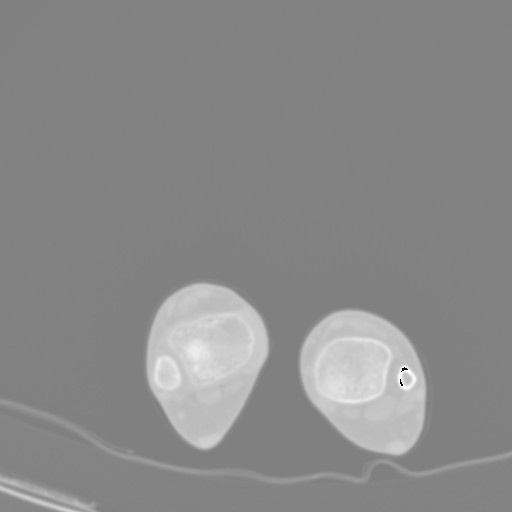

# DICOMweb + FHIR Navigator

## Linked case overview
- **Case ID:** `case_20260205_210854`
- **Patient:** `Kizzie Bode` | `female` | DOB `2006-03-30`
- **DICOM modality:** `CT`
- **Series description:** `Pied/cheville  1.0mm std`
- **Study UID:** `2.16.840.1.113669.632.20.1211.10000315526`
- **Series UID:** `1.3.12.2.1107.5.1.4.54693.30000006100507010800000005268`
- **Instance UID:** `1.3.12.2.1107.5.1.4.54693.30000006100507010800000005328`

---

## Imaging summary (JSON)
```json
{
  "series_modality": "CT",
  "series_description": "Pied/cheville  1.0mm std",
  "study_type": "Unknown",
  "body_region": "unknown",
  "laterality": "unknown",
  "key_findings": [
    "unknown"
  ],
  "urgent_flags": [
    "unknown"
  ],
  "confidence": 0.2
}
```

---

## Pre-visit packet (JSON)
```json
{
  "patient": {
    "id": "75846ad8-d173-4824-b414-f4d15f0963a3",
    "name": "Kizzie Bode",
    "gender": "female",
    "birthDate": "2006-03-30"
  },
  "conditions": [
    "Acute viral pharyngitis (disorder)",
    "Streptococcal sore throat (disorder)",
    "Acute viral pharyngitis (disorder)",
    "Acute bronchitis (disorder)"
  ],
  "observations": [
    "Body Mass Index: 16.959086140731472 kg/m2",
    "Pain severity - 0-10 verbal numeric rating [Score] - Reported: 2.1462444020395948 {score}",
    "Tobacco smoking status NHIS: Never smoker",
    "Body Mass Index: 18.302290483241404 kg/m2",
    "Body Mass Index: 20.54803176159401 kg/m2",
    "Body Height: 140.25925397242003 cm",
    "Pain severity - 0-10 verbal numeric rating [Score] - Reported: 1.1476916606724648 {score}",
    "Body Weight: 49.01933081216299 kg",
    "Tobacco smoking status NHIS: Never smoker",
    "Tobacco smoking status NHIS: Never smoker"
  ],
  "patient_summary": {},
  "imaging_summary": {},
  "triage": {},
  "questions_for_clinician": [
    "unknown",
    "unknown"
  ],
  "next_steps": [
    "unknown",
    "unknown"
  ],
  "safety_note": "unknown"
}
```

---

## Trace files
- Linked case: `artifacts/linked_case_20260205_210854.json`
- Full trace: `artifacts/navigator_v2_trace_v3_20260205_211209.json`
- Rendered image: `artifacts/dicom_render_orthanc_demo_20260205_210850.jpg`

In [11]:
import json
from pathlib import Path
from IPython.display import display, Markdown
from PIL import Image

ART_DIR = Path("artifacts")

trace_path = sorted(ART_DIR.glob("navigator_v2_trace_v3_*.json"))[-1]
trace = json.loads(trace_path.read_text(encoding="utf-8"))

case_path = Path(trace["case_path"])
case = json.loads(case_path.read_text(encoding="utf-8"))

imaging = trace["imaging_summary"]
previsit = trace["previsit_packet"]

dicom = case.get("dicom", {})
patient = case.get("patient", {})
img_path = dicom.get("image_path", "")

def md(s): 
    return str(s).replace("\n", " ").strip()

# show image
if img_path and Path(img_path).exists():
    display(Image.open(img_path))

lines = []
lines += ["# DICOMweb + FHIR Navigator", ""]
lines += ["## Linked case overview",
          f"- **Case ID:** `{md(case.get('case_id',''))}`",
          f"- **Patient:** `{md(patient.get('name',''))}` | `{md(patient.get('gender',''))}` | DOB `{md(patient.get('birthDate',''))}`",
          f"- **DICOM modality:** `{md(dicom.get('series_modality',''))}`",
          f"- **Series description:** `{md(dicom.get('series_description',''))}`",
          f"- **Study UID:** `{md(dicom.get('study_uid',''))}`",
          f"- **Series UID:** `{md(dicom.get('series_uid',''))}`",
          f"- **Instance UID:** `{md(dicom.get('sop_uid',''))}`",
          "", "---", ""]
lines += ["## Imaging summary (JSON)", "```json", json.dumps(imaging, indent=2), "```", "", "---", ""]
lines += ["## Pre-visit packet (JSON)", "```json", json.dumps(previsit, indent=2), "```", "", "---", ""]
lines += ["## Trace files",
          f"- Linked case: `{case_path}`",
          f"- Full trace: `{trace_path}`",
          f"- Rendered image: `{md(img_path)}`"]

display(Markdown("\n".join(lines)))

## ✅ Cell 7 — Gradio mini demo (interactive Navigator)

A lightweight UI to demonstrate the same pipeline interactively:
- choose a saved `linked_case_*.json`
- run the navigator
- view:
  - rendered DICOM preview
  - Imaging Summary JSON
  - Pre-visit Packet JSON

🟦 This makes the project feel like a real “navigator” rather than a one-off script.

In [12]:
import json, time, re, traceback
from pathlib import Path
from PIL import Image
import gradio as gr

ART_DIR = Path("artifacts")
ART_DIR.mkdir(exist_ok=True)

# ---- Hard check: MedGemma pipeline must exist from Cell 4
missing = []
if "pipe" not in globals(): missing.append("pipe")
if missing:
    raise RuntimeError(f"Missing {missing}. Re-run Cell 4 (MedGemma load) first, then run this cell.")

# ---- Extract assistant text from pipeline output (matches HF MedGemma examples)
def _extract_text(out):
    # pipeline returns a list; generated_text can be:
    # - list of chat messages: [{"role":"assistant","content":"..."}]
    # - string
    if isinstance(out, list) and out:
        gt = out[0].get("generated_text", out[0])
        if isinstance(gt, list):
            for msg in reversed(gt):
                if isinstance(msg, dict) and msg.get("role") == "assistant":
                    return msg.get("content", "")
            return str(gt[-1])
        return str(gt)
    return str(out)

# ---- Load a linked case by path
def _load_case(case_file: str):
    case_path = Path(case_file)
    case = json.loads(case_path.read_text(encoding="utf-8"))
    img_path = case["dicom"]["image_path"]
    img = Image.open(img_path).convert("RGB")
    return case_path, case, img_path, img

# ---- JSON extraction (balanced braces)
def _balanced_json_spans(text):
    if not isinstance(text, str):
        text = str(text)
    t = re.sub(r"```(?:json)?", "", text, flags=re.IGNORECASE)
    spans = []
    for m in re.finditer(r"\{", t):
        start = m.start()
        depth = 0
        end = None
        for i in range(start, len(t)):
            if t[i] == "{":
                depth += 1
            elif t[i] == "}":
                depth -= 1
                if depth == 0:
                    end = i + 1
                    break
        if end:
            spans.append(t[start:end])
    return spans

def _try_parse_json(s):
    s2 = re.sub(r",\s*([}\]])", r"\1", s)  # strip trailing commas
    try:
        return json.loads(s2)
    except Exception:
        return None

def extract_best_json(text, required_keys):
    best, best_score = None, -1
    for chunk in _balanced_json_spans(text):
        obj = _try_parse_json(chunk)
        if isinstance(obj, dict):
            score = sum(1 for k in required_keys if k in obj)
            if score > best_score:
                best, best_score = obj, score
    return best, best_score

def clamp01(x):
    try:
        x = float(x)
        return max(0.0, min(1.0, x))
    except Exception:
        return 0.0

def _as_list(x, default):
    if isinstance(x, list) and len(x) > 0:
        return x
    if isinstance(x, str) and x.strip():
        return [x.strip()]
    return list(default)

# ---- Correct MedGemma chat call (per model card)
def medgemma_chat(image_pil, system_text, user_text, max_new_tokens=400):
    messages = [
        {"role": "system", "content": [{"type": "text", "text": system_text}]},
        {"role": "user", "content": [
            {"type": "text", "text": user_text},
            {"type": "image", "image": image_pil},
        ]},
    ]
    out = pipe(text=messages, max_new_tokens=max_new_tokens)
    return _extract_text(out)

# ---- Core runner (returns JSONs + saved trace path + debug box)
def run_navigator(case_file):
    try:
        case_path, case, img_path, img = _load_case(case_file)

        dicom = case.get("dicom", {})
        modality = dicom.get("series_modality", "") or "unknown"
        series_desc = dicom.get("series_description", "") or "unknown"

        # EHR context
        conds = [c.get("condition", "") for c in case.get("conditions", []) if c.get("condition")]
        obs = []
        for o in case.get("observations", []):
            nm = o.get("observation", "")
            val = o.get("value", "")
            if nm:
                obs.append(f"{nm}: {val}".strip())
        ehr_ctx = {"patient": case.get("patient", {}), "conditions": conds[:8], "observations": obs[:10]}

        # 1) Imaging summary
        imaging_required = ["study_type","body_region","laterality","key_findings","urgent_flags","confidence"]
        imaging_schema = {
            "study_type": "FILL_ME",      # use metadata if helpful: CT/MR/X-ray/US/unknown
            "body_region": "FILL_ME",     # ankle/foot, chest, abdomen, head, unknown
            "laterality": "FILL_ME",      # left/right/bilateral/unknown
            "key_findings": ["FILL_ME"],  # 2-5 purely visual observations (NOT diagnosis)
            "urgent_flags": ["FILL_ME"],  # none / unknown / fracture / bleed / pneumothorax
            "confidence": 0.5             # 0..1
        }

        imaging_user = f"""
You are given a single rendered preview slice/frame. Use DICOM metadata to fill study_type/body_region when helpful.

DICOM metadata:
- series_modality: {modality}
- series_description: {series_desc}

Task:
Fill the JSON schema below with conservative, non-diagnostic, purely visual observations.
Rules:
- Return ONLY ONE JSON object. No extra text.
- Do NOT leave "FILL_ME".
- key_findings: 2–5 short visual observations (example style: "axial CT slice through ankle/foot bones", "cortical bone structures visible", "soft tissue outlines visible", "two limbs visible → bilateral", etc.)
- urgent_flags must be one of: none, unknown, fracture, bleed, pneumothorax
- confidence in [0,1]

JSON schema:
{json.dumps(imaging_schema, indent=2)}
""".strip()

        system_im = "You are a careful radiology assistant. Do not diagnose; describe what is visually present and be conservative."
        raw_im1 = medgemma_chat(img, system_im, imaging_user, max_new_tokens=350)
        imaging_obj, score1 = extract_best_json(raw_im1, imaging_required)

        if not isinstance(imaging_obj, dict) or score1 < len(imaging_required):
            raw_im2 = medgemma_chat(
                img, system_im,
                imaging_user + "\nHARD: Output must be valid JSON and must not contain FILL_ME or extra text.",
                max_new_tokens=350
            )
            imaging_obj, score2 = extract_best_json(raw_im2, imaging_required)
            raw_im = raw_im2
            im_score = score2
        else:
            raw_im = raw_im1
            im_score = score1

        # Normalize / safe fallback (but avoid the “all unknown” look)
        if not isinstance(imaging_obj, dict):
            imaging_obj = {}
        imaging_obj.setdefault("study_type", modality if modality else "unknown")
        imaging_obj.setdefault("body_region", "unknown")
        imaging_obj.setdefault("laterality", "unknown")
        imaging_obj["key_findings"] = _as_list(imaging_obj.get("key_findings"), default=[
            "Single rendered preview slice/frame",
            "Bone and soft tissue structures visible"
        ])
        imaging_obj["urgent_flags"] = _as_list(imaging_obj.get("urgent_flags"), default=["unknown"])
        imaging_obj["confidence"] = clamp01(imaging_obj.get("confidence", 0.25))

        # 2) Pre-visit packet
        previsit_required = ["patient_summary","imaging_summary","triage","questions_for_clinician","next_steps","safety_note"]
        previsit_schema = {
            "patient_summary": {
                "name": "FILL_ME",
                "age": "unknown",
                "sex": "FILL_ME",
                "key_conditions": ["FILL_ME"],
                "recent_observations": ["FILL_ME"]
            },
            "imaging_summary": imaging_obj,
            "triage": {
                "priority": "FILL_ME",     # low / medium / high / unknown
                "rationale": "FILL_ME"
            },
            "questions_for_clinician": ["FILL_ME"],
            "next_steps": ["FILL_ME"],
            "safety_note": "FILL_ME"
        }

        previsit_user = f"""
You are generating a DEMO pre-visit packet.
Important: The FHIR EHR context may be unrelated to the DICOM image. Do NOT claim causality.
If EHR and image do not align, set triage.priority="unknown" and explain why in triage.rationale.

Rules:
- Return ONLY ONE JSON object. No extra text.
- Do NOT leave "FILL_ME".
- triage.priority must be one of: low, medium, high, unknown
- questions_for_clinician: at least 2 items
- next_steps: at least 2 items
- Be conservative and non-diagnostic.

EHR context:
{json.dumps(ehr_ctx, indent=2)}

JSON schema:
{json.dumps(previsit_schema, indent=2)}
""".strip()

        system_pv = "You are a cautious clinical assistant. Keep triage conservative, avoid overclaiming, and clearly mark uncertainty."
        raw_pv1 = medgemma_chat(img, system_pv, previsit_user, max_new_tokens=650)
        previsit_obj, pscore1 = extract_best_json(raw_pv1, previsit_required)

        if not isinstance(previsit_obj, dict) or pscore1 < len(previsit_required):
            raw_pv2 = medgemma_chat(
                img, system_pv,
                previsit_user + "\nHARD: Output must be valid JSON, no FILL_ME, questions_for_clinician>=2, next_steps>=2.",
                max_new_tokens=650
            )
            previsit_obj, pscore2 = extract_best_json(raw_pv2, previsit_required)
            raw_pv = raw_pv2
            pv_score = pscore2
        else:
            raw_pv = raw_pv1
            pv_score = pscore1

        # Minimal safe fallback if needed
        if not isinstance(previsit_obj, dict):
            p = case.get("patient", {})
            previsit_obj = {
                "patient_summary": {
                    "name": p.get("name", "Unknown"),
                    "age": "unknown",
                    "sex": p.get("gender", "unknown"),
                    "key_conditions": conds[:5] if conds else ["unknown"],
                    "recent_observations": obs[:5] if obs else ["unknown"],
                },
                "imaging_summary": imaging_obj,
                "triage": {"priority": "unknown", "rationale": "Insufficient reliable info for triage from a single preview + possibly unrelated EHR."},
                "questions_for_clinician": [
                    "What is the chief complaint and mechanism of injury (if any)?",
                    "Any focal tenderness, swelling, inability to bear weight, or neurovascular symptoms?"
                ],
                "next_steps": [
                    "Review the full imaging series and any radiology report if available.",
                    "Correlate with physical exam; consider follow-up imaging if symptoms persist."
                ],
                "safety_note": "If severe pain, deformity, numbness, discoloration, or rapid worsening, seek urgent evaluation."
            }

        # Normalize lists
        previsit_obj.setdefault("imaging_summary", imaging_obj)
        previsit_obj.setdefault("triage", {"priority": "unknown", "rationale": "unknown"})
        previsit_obj["questions_for_clinician"] = _as_list(previsit_obj.get("questions_for_clinician"), default=[
            "What symptoms prompted this imaging?",
            "Any red-flag symptoms (severe pain, numbness, discoloration)?"
        ])
        previsit_obj["next_steps"] = _as_list(previsit_obj.get("next_steps"), default=[
            "Review full series/report if available.",
            "Correlate with exam findings."
        ])
        previsit_obj.setdefault("safety_note", "unknown")

        # Save demo trace
        ts = time.strftime("%Y%m%d_%H%M%S")
        demo_path = ART_DIR / f"gradio_demo_trace_{ts}.json"
        demo_path.write_text(json.dumps({
            "case_path": str(case_path),
            "image_path": img_path,
            "imaging_summary": imaging_obj,
            "previsit_packet": previsit_obj,
            "debug": {
                "imaging_score": f"{im_score}/{len(imaging_required)}",
                "previsit_score": f"{pv_score}/{len(previsit_required)}",
                "imaging_raw_head": str(raw_im)[:900],
                "previsit_raw_head": str(raw_pv)[:900],
            },
            "created_at": time.strftime("%Y-%m-%d %H:%M:%S")
        }, indent=2), encoding="utf-8")

        return img, imaging_obj, previsit_obj, str(demo_path), ""

    except Exception:
        return None, {}, {}, "", traceback.format_exc()

# ---- UI setup
case_files = sorted(str(p) for p in ART_DIR.glob("linked_case_*.json"))
if not case_files:
    raise FileNotFoundError("No linked_case_*.json found. Run the linkage cell first.")

with gr.Blocks() as demo:
    gr.Markdown("# 🧭 Navigator Demo (DICOMweb + FHIR + MedGemma)")
    gr.Markdown("Select a saved `linked_case_*.json`, then run the navigator to generate JSON outputs and a saved trace.")

    case_dd = gr.Dropdown(choices=case_files, value=case_files[-1], label="Linked case file")
    run_btn = gr.Button("Run Navigator")

    img_out = gr.Image(label="Rendered DICOM preview", type="pil")

    with gr.Row():
        out_im = gr.JSON(label="Imaging summary (JSON)")
        out_pv = gr.JSON(label="Pre-visit packet (JSON)")

    out_path = gr.Textbox(label="Saved demo trace path", interactive=False)
    err_box = gr.Textbox(label="Debug error (if any)", lines=12, interactive=False)

    run_btn.click(fn=run_navigator, inputs=[case_dd], outputs=[img_out, out_im, out_pv, out_path, err_box])

demo.queue()
demo.launch(share=True, debug=False, prevent_thread_lock=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://10619aa09ddb39dc03.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
